In [1]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
import gala.coordinates as gc
from gala.units import galactic
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
def lons_lats(pos, vel):
    prog = gd.PhaseSpacePosition(pos[0] * u.kpc, vel[0] * u.km / u.s)
    stream = gd.PhaseSpacePosition(pos[1:].T * u.kpc, vel[1:].T * u.km / u.s)
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    lon = stream_sph.lon.wrap_at(180*u.deg).degree
    lat = stream_sph.lat.degree
    return lon, lat

Defining a new function to calculate the local velocity dispersion using the median absolute deviation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_abs_deviation.html)

In [3]:
def local_mad_vrs(lons, xfs, vfs, lowper, highper, bins):

    # Transform to Galactic coordinates to get radial velocities
    galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
    galcen_distance = 8.249*u.kpc
    
    posvel_gc = SkyCoord(x=xfs[:,0]*u.kpc, y=xfs[:,1]*u.kpc, z=xfs[:,2]*u.kpc,
                     v_x=vfs[:,0]*u.km/u.s, v_y=vfs[:,1]*u.km/u.s, v_z=vfs[:,2]*u.km/u.s,
                     frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
    posvel_galactic = posvel_gc.transform_to('galactic')
    posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
    rvs = posvel_galactic_rc.radial_velocity.value
    
    # Compute data percentiles
    lower_value = np.nanpercentile(lons, lowper)
    upper_value = np.nanpercentile(lons, highper)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    vrs_mainbody = rvs[1:][(lons >= lower_value) & (lons <= upper_value)] 
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), bins)
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate standard deviation for each bin
    local_mad = np.array([mad_(vrs_mainbody[m], ignore_nan=True) for m in mask.T])
    return 1.4826 * np.nanmedian(local_mad)

Calculating this using the 5th-95th and 16th-84th percentiles of stream in its longitudinal coordinates

In [36]:
mad_rvs_5_95 = []
mad_rvs_16_84 = []

for i in range(10):
    stream = 'stream_' + str(i)

    with h5py.File('/mnt/ceph/users/rbrooks/hermes/analysis/stream-runs/combined-hdf5-files/1024-MW1-LMC3.hdf5','r') as file:
        print(np.array(file[stream]['positions']).shape)
        xs = np.array(file[stream]['positions']) #[-1]
        vs = np.array(file[stream]['velocities']) #[-1]

    lons, lats = lons_lats(xs, vs)
    mad_vr_5_95 = local_mad_vrs(lons, xs, vs, 5, 95, 50) * 1.4826 # to get standard deviation
    mad_vr_16_84 = local_mad_vrs(lons, xs, vs, 16, 84, 50) * 1.4826 # to get standard deviation
    
    mad_rvs_5_95.append(mad_vr_5_95)
    mad_rvs_16_84.append(mad_vr_16_84)


(1, 15399, 3)


ValueError: Can only change representation for ndim=3 instances.

Comparing the radial velocity MADs caluclated using the 5th-95th and 16th-84th percentiles of longitudinal data

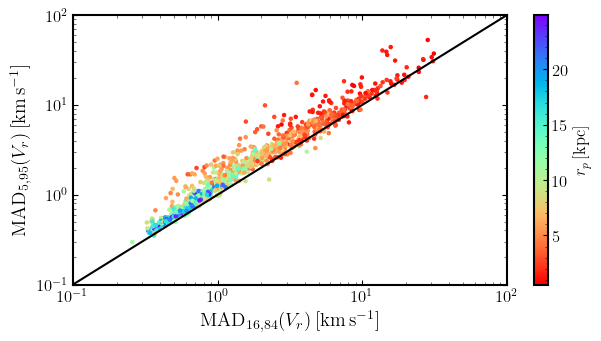

In [14]:
plt.figure(figsize=(7,3.5))
plt.scatter(np.array(mad_rvs_16_84), np.array(mad_rvs_5_95), c=pericenters, cmap='rainbow_r', s=5)

plt.plot(np.linspace(0,200,10), np.linspace(0,200,10), c='k')

plt.ylabel(r'$\mathrm{MAD}_{5,95}(V_r)\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
plt.xlabel(r'$\mathrm{MAD}_{16,84}(V_r)\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)

plt.xlim(0.1,100)
plt.ylim(0.1,100)

plt.xscale('log')
plt.yscale('log')

cbar=plt.colorbar()
cbar.set_label(r'$r_p\,[\mathrm{kpc}]$')

# plt.savefig('figures/high-vel-dis/veldis-calc/mad_lon_percentile_comp')

Comparing the radial velocity MADs caluclated using the 5th-95th OR the 16th-84th percentiles of longitudinal data against the old local velocity dispersion calculation using standard deviation of 3D vel magnitude

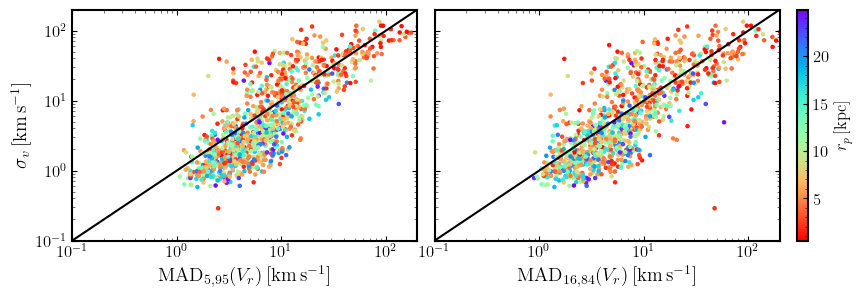

In [30]:
path = '/mnt/ceph/users/rbrooks/hermes/analysis/stream-runs/combined-hdf5-files/plotting-data/1024-MW1-LMC3.hdf5'
with h5py.File(path,'r') as file:
    pericenters = np.array(file['pericenter'])
    apocenters = np.array(file['apocenter'])
    veldis = np.array(file['loc_veldis'])
e = (apocenters - pericenters) / (apocenters + pericenters)

fig, ax = plt.subplots(1,2, figsize=(11,3), sharey='row')
plt.subplots_adjust(wspace=0.05)

plt.sca(ax[0])
plt.scatter(np.array(mad_rvs_5_95), veldis, c=pericenters, cmap='rainbow_r', s=5)
plt.plot(np.linspace(0,200,10), np.linspace(0,200,10), c='k')

plt.xlabel(r'$\mathrm{MAD}_{5,95}(V_r)\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
plt.ylabel(r'$\sigma_v\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)

plt.xlim(0.1,200)
plt.ylim(0.1,200)

plt.xscale('log')
plt.yscale('log')

plt.sca(ax[1])
plt.scatter(np.array(mad_rvs_16_84), veldis, c=pericenters, cmap='rainbow_r', s=5)
plt.plot(np.linspace(0,200,10), np.linspace(0,200,10), c='k')

plt.xlabel(r'$\mathrm{MAD}_{16,84}(V_r)\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)

cbar=plt.colorbar(ax=ax, pad=0.02)
cbar.set_label(r'$r_p\,[\mathrm{kpc}]$')

plt.xlim(0.1,200)
plt.ylim(0.1,200)

plt.xscale('log')
plt.yscale('log')

# plt.savefig('figures/high-vel-dis/veldis-calc/std_vs_mad_lon_percentiles_comp')

In [33]:
mad_rvs_5_95[928]

45.35556308259041

(0.0, 26.11609415472029)

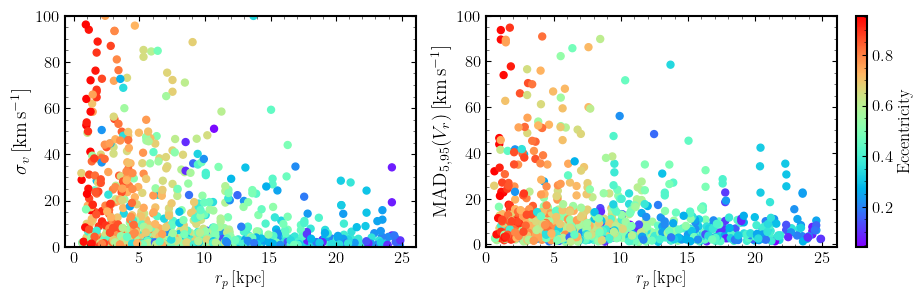

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))

plt.sca(ax[0])
plt.scatter(pericenters, veldis, c=e, cmap='rainbow')

plt.ylabel(r'$\sigma_v\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
plt.xlabel('$r_p\,[\mathrm{kpc}]$')

plt.ylim(0,100)

plt.sca(ax[1])
plt.scatter(pericenters, np.array(mad_rvs_5_95), c=e, cmap='rainbow')

plt.ylabel(r'$\mathrm{MAD}_{5,95}(V_r)\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
plt.xlabel('$r_p\,[\mathrm{kpc}]$')

plt.ylim(-1,100)
plt.xlim(0,)

# plt.sca(ax[2])
# plt.scatter(pericenters, np.array(mad_rvs_16_84), c=apocenters, cmap='rainbow', s=5)

# plt.ylabel(r'$\mathrm{MAD}_{16,84}(V_r)\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
# plt.xlabel('$r_p\,[\mathrm{kpc}]$')

cbar=plt.colorbar(ax=ax, pad=0.02)
# cbar.set_label(r'$r_a\,[\mathrm{kpc}]$')
cbar.set_label(r'Eccentricity')

plt.ylim(-1,100)
plt.xlim(0,)

# plt.savefig('figures/high-vel-dis/veldis-calc/std_mad_lon_percentile_vs_peris')
# plt.savefig('/mnt/ceph/users/rbrooks/hermes/analysis/figures/MW1-NoLMC-veldis-method-comp')


Plotting an individual stream

<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
20.831587652795264


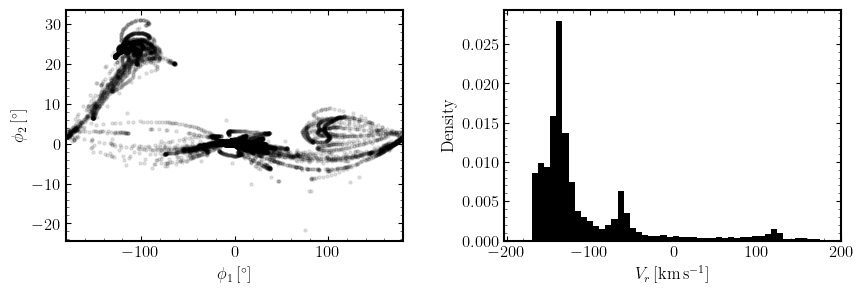

In [3]:
with h5py.File('../analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5','r') as file:
    stream = file['stream_272']
    print(stream.keys())
    xs = np.array(stream['positions'])
    vs = np.array(stream['velocities'])
    ts = np.array(stream['times'])
    sigmav = np.array(stream['loc_veldis'])
    print(sigmav)
    
lons, lats = lons_lats(xs[-1], vs[-1])

posvel_gc = SkyCoord(x=xs[-1][:,0]*u.kpc, y=xs[-1][:,1]*u.kpc, z=xs[-1][:,2]*u.kpc,
                     v_x=vs[-1][:,0]*u.km/u.s, v_y=vs[-1][:,1]*u.km/u.s, v_z=vs[-1][:,2]*u.km/u.s ,
                     frame='galactocentric', galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun)
posvel_galactic = posvel_gc.transform_to('galactic')
posvel_galactic_rc = gc.reflex_correct(posvel_galactic)
l, b, d = posvel_galactic_rc.l, posvel_galactic_rc.b,posvel_galactic_rc.distance
pm_l_cosb, pm_b, rvs = posvel_galactic_rc.pm_l_cosb, posvel_galactic_rc.pm_b, posvel_galactic_rc.radial_velocity

fig, ax  = plt.subplots(1, 2, figsize=(10,3))

plt.subplots_adjust(wspace=.3)

plt.sca(ax[0])
plt.scatter(lons, lats, c='k', alpha=.1, s=5)
plt.xlabel(r'$\phi_1\,[^{\circ}]$')
plt.ylabel(r'$\phi_2\,[^{\circ}]$')
plt.xlim(-180,180)
# plt.ylim(-49,49)

plt.sca(ax[1])
plt.hist(rvs.value, bins=50, density=True, color='k')
plt.xlabel(r'$V_r\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
plt.ylabel('Density')

# plt.savefig('figures/high-vel-dis/stream_42-wrapphi1-Vrdist')
plt.show()

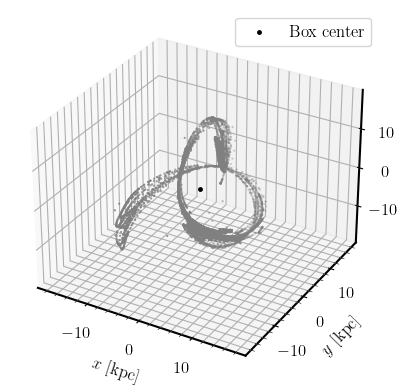

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs[-1][:, 0], 
           xs[-1][:, 1], 
           xs[-1][:, 2], 
           marker='.', c='grey', s=1, rasterized=True)
ax.scatter(0, 0, 0, s=25, edgecolors='k', facecolor='k', marker='.', label='Box center')

ax.set_xlim(-19,19)
ax.set_ylim(-19,19)
ax.set_zlim(-19,19)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.set_zlabel(r'$z$ [kpc]')

ax.legend()

In [10]:
xs[-1][0], vs[-1][0]

(array([  2.14906968,   0.33052441, -11.36277791]),
 array([ -70.68241611, -130.5514242 ,  114.48116833]))

In [13]:
vs[-1][0]*(u.km/u.s).to(u.kpc/u.Myr)

array([-0.07228777, -0.13351653,  0.11708128])